## 0.1 Mounting Drive, importing packages and initialize CUDA

In [ ]:
from google.colab import drive
#drive may already be mounted. allows access to drive data
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import random
import string
import re
import torch
import textblob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import array, asarray, zeros

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import LSTM, Bidirectional
from keras.layers import Conv1D, Flatten, GlobalMaxPooling1D, TimeDistributed
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.utils import plot_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
SEED = 6624 # Specify a seed for reproducability
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(53113)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 0.2 Check CUDA / GPU  is running 

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16663989433444724302
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15703311680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15608570455241803920
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


## 1 Load dataset and ETL

In [ ]:
local_path = '/content/drive/MyDrive/UChicago/courses/Spring 2021/NLP - Amitabh/drugproject/3_data/'
drug_reviews = pd.read_csv(local_path+'all_data.csv')
drug_reviews["rating_category"] = drug_reviews["rating_category"].astype('category')
drug_reviews["rating_cat"] = drug_reviews["rating_category"].cat.codes
drug_reviews.head(20)

,drugName,condition,review,rating,date,usefulCount,rating_category,rating_cat
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,Positive,2
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,Positive,2
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,Neutral,1
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,Positive,2
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,Positive,2
5,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2.0,"November 28, 2015",43,Negative,0
6,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1.0,"March 7, 2017",5,Negative,0
7,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10.0,"March 14, 2015",32,Positive,2
8,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1.0,"August 9, 2016",11,Negative,0
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8.0,"December 8, 2016",1,Positive,2


In [ ]:
# Number of clases to predict 
##nr_classes = 10
nr_classes = 3 # for rating_cat

# Date attribute variables 
drug_reviews['date'] =  pd.to_datetime(drug_reviews['date'])
drug_reviews['year'] = pd.DatetimeIndex(drug_reviews['date']).year
drug_reviews['month'] = pd.DatetimeIndex(drug_reviews['date']).month
drug_reviews['day'] = pd.DatetimeIndex(drug_reviews['date']).day

# No nulls
print("any nulls", drug_reviews.isnull().values.any())
drug_reviews = drug_reviews.dropna()

# DF attributes 
print(drug_reviews.shape)
drug_reviews.dtypes

any nulls True
(179742, 11)


drugName                   object
condition                  object
review                     object
rating                    float64
date               datetime64[ns]
usefulCount                 int64
rating_category          category
rating_cat                   int8
year                        int64
month                       int64
day                         int64
dtype: object

In [ ]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
emb_cols_glove = 300 #columns of glove embedding 
embeddings_dictionary_glove = dict()

embedding_path = './drive/MyDrive/UChicago/courses/Spring 2021/NLP - Amitabh/drugproject/2_scripts/embeddings'

glove_file = open(embedding_path+'/glove.6B.300d.txt', "r", encoding='utf-8')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary_glove[word] = vector_dimensions

glove_file.close()

In [ ]:
emb_cols_twitter = 150 #columns of twitter embedding 
embeddings_dictionary_twitter = dict()

embedding_path = './drive/MyDrive/UChicago/courses/Spring 2021/NLP - Amitabh/drugproject/2_scripts/embeddings'

twitter_file = open(embedding_path+'/twitter_embeddings.txt', "r", errors = 'ignore', encoding='utf-8')
for line in twitter_file:
    records = line.split()
    records = ['0' if x=='1\\/2' else x for x in records] # there was an error character. This erases it 
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary_twitter[word] = vector_dimensions

twitter_file.close()

## 2 Mixed attribute model: Metadata + review text 

In [ ]:
X = drug_reviews.drop('rating', axis=1)
X = X.drop('rating_cat', axis=1) # y target
X = X.drop('date', axis=1)
X = X.drop('rating_category', axis=1)
#I am dropping drugName since one-hot-encoding of it makes collab crash
X = X.drop('drugName', axis=1)

X = pd.get_dummies(X, prefix=['C'], columns=['condition'])

y = drug_reviews['rating_cat']

#### 2.1 POS features  

In [ ]:
## Counts and words/sentence density
X['char_count'] = X['review'].apply(len)
X['word_count'] = X['review'].apply(lambda x: len(x.split()))
X['word_density'] = X['char_count'] / (X['word_count']+1)

X['sentence_count'] = X["review"].apply(lambda x: len(str(x).split(".")))
X['avg_word_length'] = X['char_count'] / X['word_count']
X['avg_sentence_lenght'] = X['word_count'] / X['sentence_count']

X['punctuation_count'] = X['review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
X['title_word_count'] = X['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
X['upper_case_word_count'] = X['review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


## POS information 
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt


X['noun_count'] = X['review'].apply(lambda x: check_pos_tag(x, 'noun'))
X['verb_count'] = X['review'].apply(lambda x: check_pos_tag(x, 'verb'))
X['adj_count'] = X['review'].apply(lambda x: check_pos_tag(x, 'adj'))
X['adv_count'] = X['review'].apply(lambda x: check_pos_tag(x, 'adv'))
X['pron_count'] = X['review'].apply(lambda x: check_pos_tag(x, 'pron'))

"\nTHIS TAKES A LOT, start 10pm \n\nX['noun_count'] = X['review'].apply(lambda x: check_pos_tag(x, 'noun'))\nX['verb_count'] = X['review'].apply(lambda x: check_pos_tag(x, 'verb'))\nX['adj_count'] = X['review'].apply(lambda x: check_pos_tag(x, 'adj'))\nX['adv_count'] = X['review'].apply(lambda x: check_pos_tag(x, 'adv'))\nX['pron_count'] = X['review'].apply(lambda x: check_pos_tag(x, 'pron'))\n"

#### 2.2 Encoders, tokenizers and embedding matrices

In [ ]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

X_train, X_test, y_aux, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

y_train = to_categorical(y_aux)
y_test = to_categorical(y_test)

In [ ]:
X1_train = []
sentences = list(X_train["review"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))

In [ ]:
X1_test = []
sentences = list(X_test["review"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

In [ ]:
embedding_matrix_glove = zeros((vocab_size, emb_cols_glove))
for word, index in tokenizer.word_index.items():
    embedding_vector_glove = embeddings_dictionary_glove.get(word)
    if embedding_vector_glove is not None:
        embedding_matrix_glove[index] = embedding_vector_glove

In [ ]:
embedding_matrix_twitter = zeros((vocab_size, emb_cols_twitter))
for word, index in tokenizer.word_index.items():
    embedding_vector_twitter = embeddings_dictionary_twitter.get(word)
    if embedding_vector_twitter is not None:
        embedding_matrix_twitter[index] = embedding_vector_twitter

In [ ]:
X2_train = X_train.drop('review', axis=1)
X2_test = X_test.drop('review', axis=1)

#### 2.3 Training 

In [ ]:
#Input layers 
input_0 = Input(shape=(maxlen,)) #text layer
input_1 = Input(shape=(maxlen,)) #text layer 
input_2 = Input(shape=(len(X2_train.columns),)) #numerical vars 

## Text submodel - Twitter embedding 
embedding_layer0 = Embedding(vocab_size, emb_cols_twitter, weights=[embedding_matrix_twitter], 
                            trainable=True)(input_0) ## trainable embeddings 
LSTM_Layer_0 = Bidirectional(LSTM(256, dropout = 0.5, recurrent_dropout = 0.5))(embedding_layer0)  

## Text submodel - Glove  embedding
embedding_layer1 = Embedding(vocab_size, emb_cols_glove, weights=[embedding_matrix_glove], 
                            trainable=True)(input_1) ## trainable embeddings 
LSTM_Layer_1 = Bidirectional(LSTM(256, dropout = 0.5, recurrent_dropout = 0.5))(embedding_layer1)  

## Numeric submodel 
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

## Concatenate models 
concat_layer = Concatenate()([LSTM_Layer_0, LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(nr_classes, activation='softmax')(dense_layer_3)
model = Model(inputs=([input_0, input_1, input_2]), outputs=output)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1016)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 150)     7799550     input_1[0][0]                    
______________________________________________________________________________________________

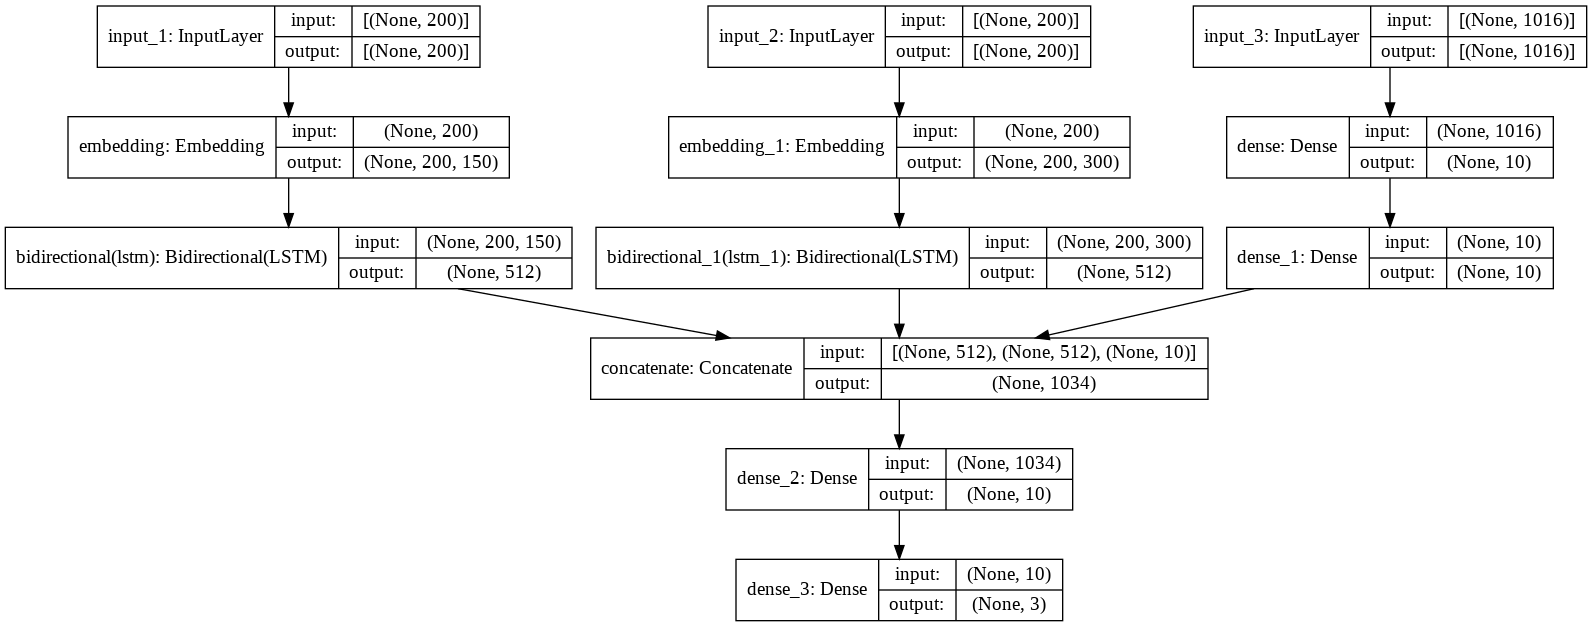

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
print(model.summary())
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [ ]:
NUM_EPOCHS = 10
history = model.fit(x=[X1_train, X1_train, X2_train], y=y_train, batch_size=64, 
                    epochs=NUM_EPOCHS, verbose=1, validation_split=0.15) 

Epoch 1/10
1910/1910 [==============================] - 5678s 3s/step - loss: 0.8025 - acc: 0.6774 - val_loss: 0.5378 - val_acc: 0.7858
Epoch 2/10
1910/1910 [==============================] - 5627s 3s/step - loss: 0.5301 - acc: 0.7891 - val_loss: 0.5025 - val_acc: 0.8010
Epoch 3/10
1910/1910 [==============================] - 5621s 3s/step - loss: 0.4703 - acc: 0.8122 - val_loss: 0.4811 - val_acc: 0.8056
Epoch 4/10
1910/1910 [==============================] - 5447s 3s/step - loss: 0.4310 - acc: 0.8274 - val_loss: 0.4763 - val_acc: 0.8128
Epoch 5/10
1910/1910 [==============================] - 5321s 3s/step - loss: 0.3958 - acc: 0.8433 - val_loss: 0.4923 - val_acc: 0.8085
Epoch 6/10
1910/1910 [==============================] - 5473s 3s/step - loss: 0.3696 - acc: 0.8542 - val_loss: 0.5035 - val_acc: 0.8003
Epoch 7/10
1910/1910 [==============================] - 5452s 3s/step - loss: 0.3490 - acc: 0.8618 - val_loss: 0.5213 - val_acc: 0.8106
Epoch 8/10
1910/1910 [==========================

In [ ]:
model.save(local_path+f'/model_multiatt_both_drops_{NUM_EPOCHS}')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/UChicago/courses/Spring 2021/NLP - Amitabh/drugproject/3_data//model_multiatt_both_drops_10/assets


In [ ]:
score = model.evaluate(x=[X1_test, X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1124/1124 [==============================] - 408s 363ms/step - loss: 0.5674 - acc: 0.8048
Test Score: 0.5673615336418152
Test Accuracy: 0.8047511577606201


#### 2.4 Plots

In [ ]:
import altair as alt
def training_lines(training_accuracies, validation_accuracies, test_accuracy, title=None):
  '''
  Inputs:
  training_accuracies: list of length n of the training accuracies obtained at each epoch
  validation_accuries: list of length n of the trianing accuracies obtained at each epoch
  test_accuracy: integer of the highest test score attained
  '''
  epochs = list(map(lambda accs: accs+1, range((len(training_accuracies)))))
  train_df= pd.DataFrame({"accuracy":training_accuracies, "epoch":epochs})
  train_df["Dataset"] = "Training accuracy"
  valid_df = pd.DataFrame({"accuracy":validation_accuracies, "epoch":epochs})
  valid_df["Dataset"] = "Validation accuracy"
  test = [test_accuracy]*len(epochs)
  test_df =pd.DataFrame({"epoch":epochs, "accuracy":test})
  test_df['Dataset'] = "Optimum Test accuracy"
  #df = pd.concat([train_df, valid_df, test_df])
  df = pd.concat([train_df, valid_df])
  df['epoch']= df['epoch'].apply(lambda ep: int(ep))
  min_y_axis = min(min(training_accuracies),min(validation_accuracies), test_accuracy) - 0.1

  print(df)

  line_chart = alt.Chart(df).mark_line(point=True).encode(
      x=alt.X("epoch:Q", axis=alt.Axis(tickMinStep=1)),
      y=alt.Y("accuracy", scale=alt.Scale(domain=[min_y_axis, 1])),
      color='Dataset'
  )

  test_line = alt.Chart(test_df).mark_line(strokeDash=[7,1]).encode(
      x=alt.X("epoch:Q", axis=alt.Axis(tickMinStep=1)),
      y=alt.Y("accuracy", scale=alt.Scale(domain=[min_y_axis, 1])),
      color='Dataset'
  )

  return (line_chart + test_line).properties(title={'text': (title if title else "")})

In [ ]:
training_lines(history.history['acc'], history.history['val_acc'], score[1])

   accuracy  epoch              Dataset
0  0.727975      1    Training accuracy
1  0.792602      2    Training accuracy
2  0.812950      3    Training accuracy
3  0.827374      4    Training accuracy
4  0.840113      5    Training accuracy
5  0.850471      6    Training accuracy
6  0.859504      7    Training accuracy
7  0.868946      8    Training accuracy
8  0.875507      9    Training accuracy
9  0.882781     10    Training accuracy
0  0.785757      1  Validation accuracy
1  0.800964      2  Validation accuracy
2  0.805601      3  Validation accuracy
3  0.812833      4  Validation accuracy
4  0.808522      5  Validation accuracy
5  0.800315      6  Validation accuracy
6  0.810561      7  Validation accuracy
7  0.804998      8  Validation accuracy
8  0.800408      9  Validation accuracy
9  0.802494     10  Validation accuracy


alt.LayerChart(...)

In [ ]:
def confusion_matrix(df, predicted_col, actual_col, title=None, share=True):
  matrix = df.groupby([predicted_col, actual_col]).size().reset_index(name='count')
  matrix['share'] = matrix['count'] / len(df)
  max_count = max(matrix['count'])
  base =  alt.Chart(matrix)
  heatmap = base.mark_rect().encode(
      x=alt.X(predicted_col+':O',title="Predicted Class"),
      y=alt.Y(actual_col+':O', title="Actual Class"),
      color=alt.Color(("share" if share else "count")+':Q', scale=alt.Scale(
                        scheme='greens', domain=[0,(1 if share else max_count)]),
                        legend=alt.Legend(
                        title= ("Share" if share else "Count"))
      )
  )
  text = base.mark_text(align='center', baseline='middle').encode(
    x=alt.X(predicted_col+':O'),
    y=alt.Y(actual_col+':O'),
    text='count',
    color=alt.value('black')
    )
  
  return (heatmap + text).properties(
      width=500, height=500,
      title={'text': (title if title else "")})

In [ ]:
predictions = model.predict_classes(x=[X1_test, X1_test, X2_test])
predict_class = np.argmax(predictions,axis=1)
true_class = np.argmax(y_test,axis=1)
prediction_df = pd.DataFrame({'true':true_class, 'predicted':predict_class})

In [ ]:
confusion_matrix(prediction_df, "predicted", "true", title="Confusion Matrix", share=True)

alt.LayerChart(...)

In [ ]:
print("Kappas:", sklearn.metrics.cohen_kappa_score(prediction_df.true, prediction_df.predicted))
print("Weighted F1:", sklearn.metrics.f1_score(prediction_df.true, prediction_df.predicted, average='weighted'))
pd.crosstab(prediction_df.true, prediction_df.predicted)

Kappas: 0.6295115866909142
Weighted F1: 0.795807357094633


predicted,0,1,2
true,,,
0,7792,885,972
1,1468,1129,1650
2,1037,1007,20009
